# Imports

In [75]:
import pickle
import os
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from wordcloud import WordCloud
from spellchecker import SpellChecker
from sklearn.model_selection import train_test_split
import re
import nltk
import contractions
import spacy
from scipy.sparse import hstack
from datetime import datetime
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.naive_bayes import GaussianNB, MultinomialNB

from xgboost import XGBClassifier

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /home/vasco/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/vasco/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [76]:
# Reading the file and converting it to a DataFrame
def read_file_to_dataframe(filename):
    data = []
    
    with open("./data/" + filename, 'r', encoding='utf-8') as file:
        for linha in file:
            linha = linha.strip()  # Remove leading/trailing spaces and newlines
            filme = linha.split('\t')  # Split by tab
            data.append(filme)  # Append the row to the data list
    
    # Convert the list of rows to a pandas DataFrame
    df = pd.DataFrame(data)
    
    return df


In [77]:
# Reading csv file and converting it to a DataFrame
def read_csv_to_dataframe(filename):
    df = pd.read_csv("./data/" + filename)
    return df

In [78]:
# Filtering dataframe for genres in our list and rows with all collumnds filled
def filter_dataframe(df, genres):
    df = df[df['Genre'].isin(genres)]
    df = df.dropna()
    return df

In [79]:
# Add headers to train.txt dataframe

def addHeadersToTrain(df):
    df.columns = ['Title','Origin/Ethnicity' ,'Genre', 'Director', 'Plot']
    return df

In [80]:
# Balance dataset (Remove from drama)

def balance_dataset(df):
    drama_movies = df[df['Genre'] == 'drama']
    random_drama_sample = drama_movies.sample(n=500, random_state=42)  # random_state ensures reproducibility
    df = df.drop(random_drama_sample.index)
    return df

In [81]:
# Try to increase Sci-fi

#TODO - Ir ao filmesDataset, pegar nos filmes sci-fi
#TODO - Comparar com o train.txt para não haver repetidos
#TODO - Comparar com o test.txt para não haver repetidos
#TODO - Adicionar ao train.txt

import pandas as pd

def increase_scifi(df):
    # Assuming read_csv_to_dataframe and read_file_to_dataframe are defined elsewhere
    filmesDataset = read_csv_to_dataframe('filmesDataset.csv')
    top_secret = read_file_to_dataframe('top_secret_69.txt')
    top_secret.columns = ['Title', 'Origin/Ethnicity', 'Director', 'Plot']
    
    # Filter for sci-fi movies
    sci_fi_movies = filmesDataset[filmesDataset['Genre'] == 'sci-fi']

    # Identify unique sci-fi movies not in df or top_secret
    unique_sci_fi_movies = sci_fi_movies[~sci_fi_movies['Title'].isin(df['Title'])]
    unique_sci_fi_movies = unique_sci_fi_movies[~unique_sci_fi_movies['Title'].isin(top_secret['Title'])]

    print(len(unique_sci_fi_movies)) 

    return df


def dupSci_fi(df):
    sci_fi_movies = df[df['Genre'] == 'sci-fi']

    # Duplicate the sci-fi movies
    duplicated_movies = pd.concat([sci_fi_movies] * 2, ignore_index=True)  # Duplicating by concatenating

    # Combine original DataFrame with the duplicated movies
    new_df = pd.concat([df, duplicated_movies], ignore_index=True)

    # Shuffle the DataFrame to maintain randomness
    new_df = new_df.sample(frac=1, random_state=42).reset_index(drop=True)

    return new_df

# Variaveis onde está os ficheiros de treino e o modelo

In [82]:
#file onde já está o modelo treinado"
model=None

#limpesa de ficheiro de treino
# data="filmesDataset"
data= "train2"
#ficheiro onde vai ser feita ao autoavaliacao
avaliation = "test_no_labels"

In [83]:
print("\033[34mData to DataFrame\n\033[0m")
# Example usage
allowed_genres = ["drama", "comedy", "horror", "action", "romance", "western", "animation", "crime", "sci-fi"]

# df = read_csv_to_dataframe(data+".csv")
# df = df.drop(columns=['Unnamed: 8'])
df = read_file_to_dataframe(data+".txt")
df = addHeadersToTrain(df)
df = filter_dataframe(df, allowed_genres)
# df = balance_dataset(df)
# df = increase_scifi(df)
# df = dupSci_fi(df)
print(df)


Data to DataFrame

                                     Title Origin/Ethnicity      Genre  \
0                           Unknown island         American     sci-fi   
1                            Space Marines         American     sci-fi   
2                            Small quacker         American  animation   
3                                 Dinosaur         American  animation   
4                           As Tears Go By        Hong Kong      crime   
...                                    ...              ...        ...   
9982  Al-Malak al-Zalem (The Unjust Angel)         Egyptian      drama   
9983                              Homicide         American      drama   
9984                            D.A.R.Y.L.         American     sci-fi   
9985                                 Chuka         American    western   
9986                                Maniac         American     horror   

                         Director  \
0                   Jack Bernhard   
1                 

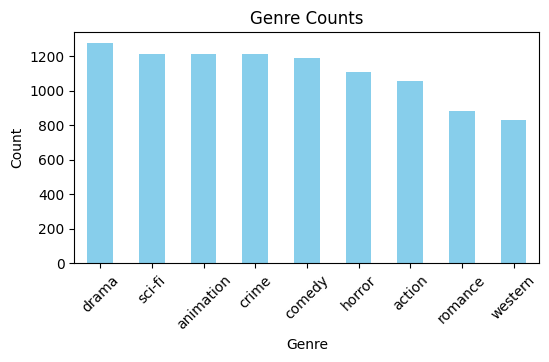

Genre
drama        1276
sci-fi       1212
animation    1212
crime        1212
comedy       1193
horror       1108
action       1059
romance       886
western       829
Name: count, dtype: int64


In [84]:
# Genre Count for train dataset

genre_counts = df['Genre'].value_counts()

# Plot the histogram
plt.figure(figsize=(6, 3))
genre_counts.plot(kind='bar', color='skyblue')
plt.title('Genre Counts')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()
print(genre_counts)

9987
Average word count: 377.87


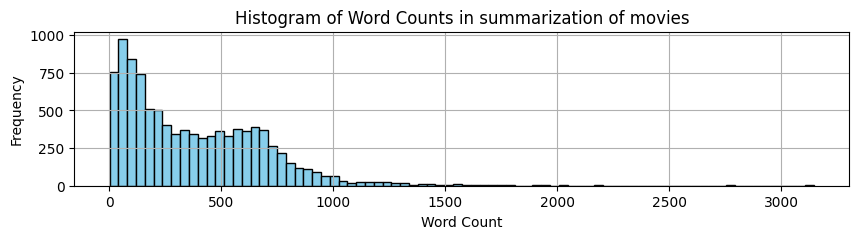

In [85]:
# histogram of word count
print(len(df))


df['word_count'] = df['Plot'].apply(lambda x: len(x.split())) 
avg_word_count = df['word_count'].mean()
print(f'Average word count: {avg_word_count:.2f}')
# Plotting the histogram of word counts
plt.figure(figsize=(10, 2))
plt.hist(df['word_count'], bins=80, color='skyblue', edgecolor='black')
plt.title('Histogram of Word Counts in summarization of movies')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


the: 219063
to: 140528
and: 133122
a: 101851
of: 73274
is: 60429
in: 55556
his: 52708
that: 40446
he: 37555


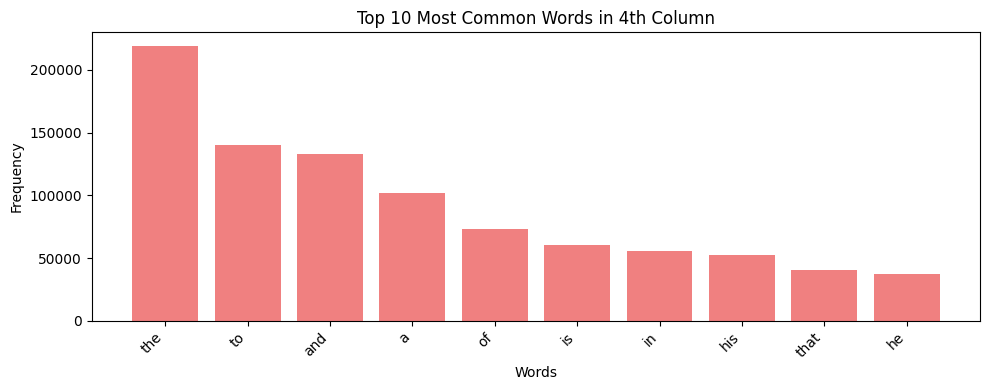

In [86]:
# Flatten all words from the 4th column into a single list
all_words = [word for row in df['Plot'] for word in row.split()]

word_counter = Counter(all_words)

top_10_words = word_counter.most_common(10)

for word, count in top_10_words:
    print(f"{word}: {count}")

words, counts = zip(*top_10_words)

plt.figure(figsize=(10, 4))
plt.bar(words, counts, color='lightcoral')
plt.title('Top 10 Most Common Words in 4th Column')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')  # Rotate word labels for better readability
plt.tight_layout()
plt.show()

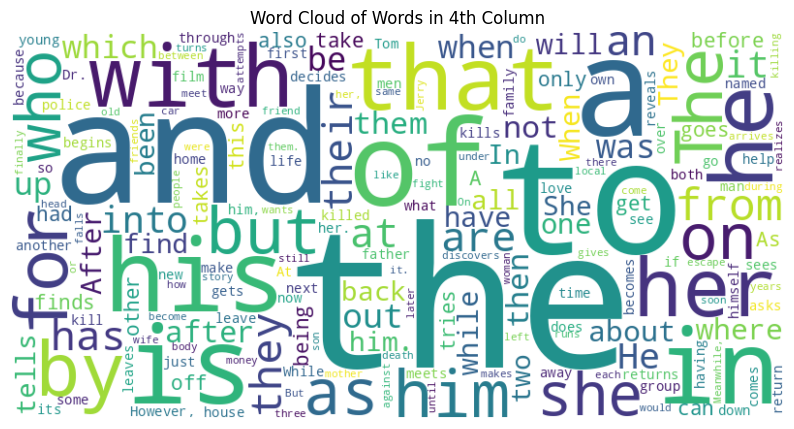

In [87]:
# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counter)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off the axis
plt.title('Word Cloud of Words in 4th Column')
plt.show()

In [88]:
# Check for typos using the pyspellchecker
spell = SpellChecker()
misspelled_words = spell.unknown(all_words)  # Identify misspelled words

# Display the number of potential typos
print(f"Number of potential typos: {len(misspelled_words)}")

# Optionally, print the misspelled words
print("\nPotential typos detected:")
for word in misspelled_words:
    print(word)

Number of potential typos: 121971

Potential typos detected:
voters,
manohar
vedanayagam,
katzenbach
painting.having
chandhini
karras,
fever;
wall-mounted
bobo;
paprizzios.
(williams),
(ann-margret).
finishes.
by,
fate:
hayter)
molière,
("the
(themselves
cheung's
agreed,
combes),
denham,
violently.
burial,
bedford).
mouse,
paraman
transfusion.
supermarket,
rajkumari,
drumstick.the
vasudev's
prouts
sunters),
malaya
gabor.
clinginess
hain..!
top-secret,
mankind.
briany
delays.
arati(madhu)
him.excess
vivien
-downstream,
halt,
airtel
price).
1883,
grihasthi
cave!
mick.
warships,
(sergej
(donahue
indeedto
souvenirs.
eden
flustered,
mate;
space).
al-ghazi,
hurrin
mccandless'
annex;
sandalwood.
(1,700
sources.
fiske,
rumi's
mayerik
shapiro),
arivu
grandview
kero,
jack-o-lantern,
dory.
pokémon.
steel-lined
manasvini,
elinor,
(jyothika).
hokage's
namesake)
'dai
shastri).
oil.trent
panch,
anddil
americans—while
quickof
llandudno.
judd
kiranmayi
ruse:
u-571,
launchers,
phooey.
rasegans
elected;


## Pre Processamento

In [89]:
# Function to standardize dates
def standardize_dates(text):
    def _month_to_number(month_name):
        try:
            return datetime.strptime(month_name, "%b").month  # Abbreviated month names (e.g., "Feb")
        except ValueError:
            try:
                return datetime.strptime(month_name, "%B").month  # Full month names (e.g., "February")
            except ValueError:
                return None  # Return None for invalid month names

    def _handle_two_digit_year(year):
        if not year:  # If year is None or empty
            return ""
        year = int(year)
        return year + 2000 if year < 100 else year

    # Date normalization using regex
    text = re.sub(
        r'(\b[A-Za-z]+) (\d{1,2})(?:st|nd|rd|th)?(?:,)? (\d{4})?',
        lambda match: (
            f"{int(match.group(2)):02d}/{_month_to_number(match.group(1)):02d}/{match.group(3)}"
            if _month_to_number(match.group(1)) is not None and match.group(3)  # Ensure month and year exist
            else f"{int(match.group(2)):02d}/{_month_to_number(match.group(1)):02d}"
            if _month_to_number(match.group(1)) is not None  # Ensure month exists
            else match.group(0)  # Return original text if invalid month
        ),
        text
    )

    # Handle formats like "8-Feb-2013"
    text = re.sub(
        r'(\d{1,2})(?:st|nd|rd|th)?[-/.](\b[A-Za-z]+)\b[-/.]?(\d{2,4})?',
        lambda match: (
            f"{int(match.group(1)):02d}/{_month_to_number(match.group(2)):02d}/{_handle_two_digit_year(match.group(3))}"
            if _month_to_number(match.group(2)) is not None and match.group(3)  # Ensure month and year exist
            else f"{int(match.group(1)):02d}/{_month_to_number(match.group(2)):02d}"
            if _month_to_number(match.group(2)) is not None  # Ensure month exists
            else match.group(0)  # Return original text if invalid month
        ),
        text
    )

    return text

In [90]:
# lowercasing
def lowercase_text(text):
    return text.lower()

In [91]:
nlp = spacy.load("en_core_web_sm")

def lemmatize_text(text):
    # Process the text with spaCy
    doc = nlp(text)
    # Extract and return lemmatized words
    lemmatized_words = [token.lemma_ for token in doc]
    return " ".join(lemmatized_words)

In [92]:
# stop words
stop_words = set(stopwords.words('english'))
def remove_stopwords(text, stop_words=stop_words):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words and word.lower()]
    return " ".join(filtered_words)

In [93]:
#contractions
def expand_contractions(text):
    if not isinstance(text, str) or not text:
        # Return an empty string or the original text if it's not a valid string
        return text

    try:
        # Use contractions.fix to expand contractions in the text
        return contractions.fix(text)
    except IndexError as e:
        print(f"IndexError encountered: {e}")
        # Optionally return the original text if there's an error
        return text


In [94]:
# Remove punctuation except for specific cases like "Dr." or "Mr."
def remove_punctuation(text):
    # Replace specific abbreviations with placeholders
    text = re.sub(r'\b(Dr|Mr|Ms|Mrs)\.', r'\1_PLACEHOLDER_', text)
    
    # Remove all punctuation
    text = re.sub(r'[^\w\s]', '', text)
    
    # Restore the abbreviations
    text = text.replace('_PLACEHOLDER_', '.')
    
    return text

In [95]:
def remove_references(text):
    # Substituir ".[\d]" por "."
    text = re.sub(r'\.\[\d+\]', '.', text)
    
    return text

In [96]:
print("\033[34mPre Processing the data\n\033[0m")
line_counter = 0

def preprocess_text(text):
    global line_counter
    print(f"Processing line {line_counter + 1}...")   # Print the line being processed
    line_counter += 1 
    text = expand_contractions(text)       # Step 1: Expand contractions
    text = standardize_dates(text)         # Step 2: Normalize dates
    text = lowercase_text(text)            # Step 3: Convert to lowercase
    text = remove_punctuation(text)        # Step 4: Remove punctuation but keep specific cases
    text = remove_stopwords(text)          # Step 5: Remove stopwords
    text = lemmatize_text(text)            # Step 6: Lemmatize the text
    text = remove_references(text)         # Step 7: Remove references
    return text

# Example usage

Pre Processing the data



In [97]:
df['Plot'] = df['Plot'].apply(preprocess_text)

print("\033[32mPre Processing Completed!\n\033[0m")

Processing line 1...
Processing line 2...
Processing line 3...
Processing line 4...
Processing line 5...
Processing line 6...
Processing line 7...
Processing line 8...
Processing line 9...
Processing line 10...
Processing line 11...
Processing line 12...
Processing line 13...
Processing line 14...
Processing line 15...
Processing line 16...
Processing line 17...
Processing line 18...
Processing line 19...
Processing line 20...
Processing line 21...
Processing line 22...
Processing line 23...
Processing line 24...
Processing line 25...
Processing line 26...
Processing line 27...
Processing line 28...
Processing line 29...
Processing line 30...
Processing line 31...
Processing line 32...
Processing line 33...
Processing line 34...
Processing line 35...
Processing line 36...
Processing line 37...
Processing line 38...
Processing line 39...
Processing line 40...
Processing line 41...
Processing line 42...
Processing line 43...
Processing line 44...
Processing line 45...
Processing line 46.

find: 11499
kill: 11107
take: 10717
go: 9369
leave: 9356
get: 8603
one: 8101
man: 7858
tell: 7733
back: 7051


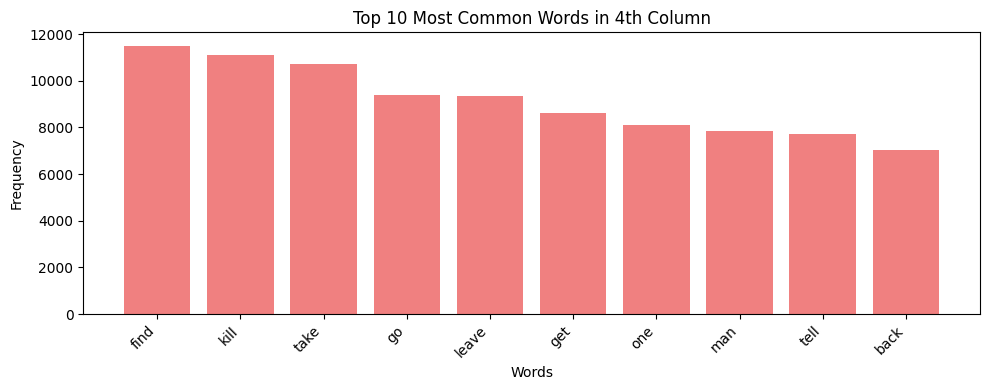

In [98]:
# Flatten all words from the 4th column into a single list after pre-processing
all_words = [word for row in df['Plot'] for word in row.split()]

word_counter = Counter(all_words)

top_10_words = word_counter.most_common(10)

for word, count in top_10_words:
    print(f"{word}: {count}")

words, counts = zip(*top_10_words)

plt.figure(figsize=(10, 4))
plt.bar(words, counts, color='lightcoral')
plt.title('Top 10 Most Common Words in 4th Column')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')  # Rotate word labels for better readability
plt.tight_layout()
plt.show()

# Data after Pre Processing

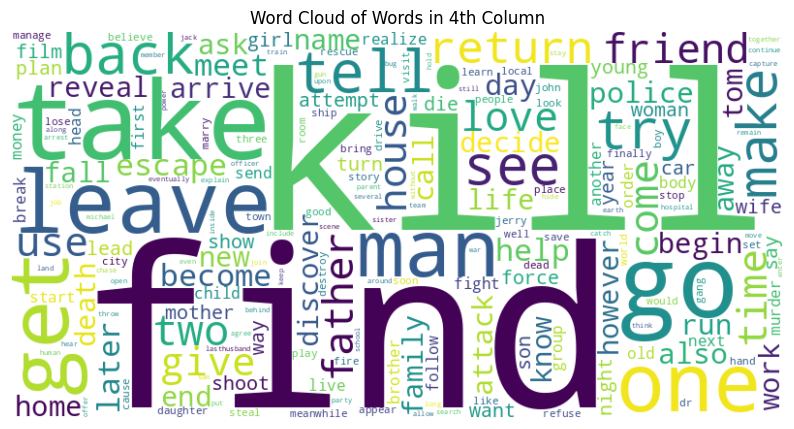

In [99]:
# Generate a word cloud after pre-processing
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counter)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off the axis
plt.title('Word Cloud of Words in 4th Column')
plt.show()

## Carregar o modelo ou Criar um novo
#### Conforme o nome dado a variavel 'pklToUse'

==== SVM ====
Resultados com tfidf
              precision    recall  f1-score   support

      action       0.71      0.63      0.67       119
   animation       0.93      0.92      0.92       120
      comedy       0.60      0.61      0.60       123
       crime       0.80      0.85      0.82       118
       drama       0.57      0.60      0.58       127
      horror       0.87      0.84      0.86       103
     romance       0.53      0.49      0.51        83
      sci-fi       0.95      0.99      0.97       130
     western       0.91      0.91      0.91        76

    accuracy                           0.76       999
   macro avg       0.76      0.76      0.76       999
weighted avg       0.76      0.76      0.76       999



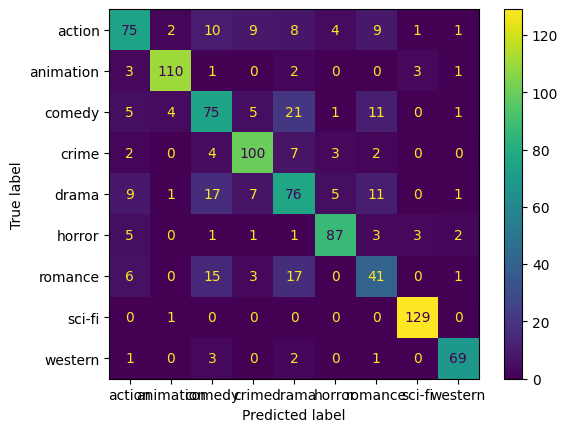

In [100]:
pklToUse = "balancedDatasetTFIDFSVMPlot"

tfidf_vectorizer = TfidfVectorizer(max_features=10000)
if os.path.isfile("data/"+pklToUse+'.pkl'):
    print("\033[34mLoading Model\n\033[0m")
    with open('data/'+pklToUse+'.pkl', 'rb') as f:
        clf, tfidf_vectorizer = pickle.load(f)
else:
    indices = range(len(df))
    train_indices, test_indices, y_train, y_test = train_test_split(indices, df['Genre'], test_size=0.1, random_state=42)  # random_state=42 ensures reproducibility

    # Initialize vectorizer (fitting only on the training data)

    # Fit on training data
    data_train = tfidf_vectorizer.fit_transform(df['Plot'].iloc[train_indices]).toarray()

    # Transform the test data (no fitting, just transform)
    data_test = tfidf_vectorizer.transform(df['Plot'].iloc[test_indices]).toarray()

    # One-hot encode the categorical features 
    
    # encoder = OneHotEncoder(handle_unknown='ignore') 
    # data_train_categorical = encoder.fit_transform(df.iloc[train_indices][['Director']])
    # data_test_categorical = encoder.transform(df.iloc[test_indices][['Director']])

    # Com o train.txt nao há release year
    # Quando se descomentar adicionar ao stack
    
    # scaler = MinMaxScaler()
    # data_train_numerical = scaler.fit_transform(df[['Release Year']].iloc[train_indices].astype(int))
    # data_test_numerical = scaler.transform(df[['Release Year']].iloc[test_indices].astype(int))

    # Join tfidf of plot and other features
    # STACK
    # data_train = hstack([data_train, data_train_categorical])
    # data_test = hstack([data_test, data_test_categorical])

    y = df['Genre']      # Check if the appropriate collumn name is 'category'
    labels = np.unique(y).tolist()

    print("==== SVM ====")
    clf = svm.SVC(kernel='linear') # kernel{‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’}

    print("Resultados com tfidf")
    clf.fit(data_train, y_train)
    x_pred=clf.predict(data_test)
    print(classification_report(y_pred=x_pred, y_true=y_test, labels = labels, zero_division=1.))

    confusion_matrix(y_test, x_pred)

    cm = confusion_matrix(y_test, x_pred, labels=clf.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
    disp.plot()
    plt.show()

    # Save the SVM model
    i = 0
    if i == 1:
        with open('data/'+pklToUse+'.pkl', 'wb') as f:
            pickle.dump((clf, tfidf_vectorizer), f)

In [101]:
top_secret = read_file_to_dataframe("top_secret_69.txt")
print(top_secret.shape[0])

370


In [102]:
print("\033[34mPre Processing the top secret\n\033[0m")

line_counter = 0
top_secret.iloc[:, 2] = top_secret.iloc[:, 2].apply(preprocess_text)
print("\033[32mPre Processing of Our Data Completed!\n\033[0m")

Pre Processing the top secret

Processing line 1...
Processing line 2...
Processing line 3...
Processing line 4...
Processing line 5...
Processing line 6...
Processing line 7...
Processing line 8...
Processing line 9...
Processing line 10...
Processing line 11...
Processing line 12...
Processing line 13...
Processing line 14...
Processing line 15...
Processing line 16...
Processing line 17...
Processing line 18...
Processing line 19...
Processing line 20...
Processing line 21...
Processing line 22...
Processing line 23...
Processing line 24...
Processing line 25...
Processing line 26...
Processing line 27...
Processing line 28...
Processing line 29...
Processing line 30...
Processing line 31...
Processing line 32...
Processing line 33...
Processing line 34...
Processing line 35...
Processing line 36...
Processing line 37...
Processing line 38...
Processing line 39...
Processing line 40...
Processing line 41...
Processing line 42...
Processing line 43...
Processing line 44...
Processing

Accuracy: 57.03
              precision    recall  f1-score   support

      action       0.62      0.67      0.64        58
   animation       0.57      0.31      0.40        13
      comedy       0.41      0.48      0.44        54
       crime       0.44      0.62      0.52        26
       drama       0.47      0.60      0.53        65
      horror       0.80      0.63      0.70        59
     romance       0.62      0.44      0.52        52
      sci-fi       0.00      1.00      0.00         0
     western       0.96      0.77      0.86        35

   micro avg       0.57      0.58      0.58       362
   macro avg       0.54      0.61      0.51       362
weighted avg       0.61      0.58      0.59       362



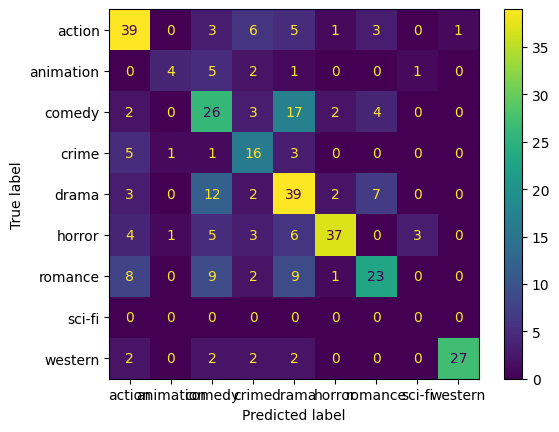

In [103]:
X_new = tfidf_vectorizer.transform(top_secret.iloc[:, 3]).toarray()  # Transform it into the TF-IDF format

# Step 3: Predict the genre using the trained MLP model
y_new_pred = clf.predict(X_new)

accuracy = accuracy_score(top_secret.iloc[:, 2], y_new_pred)

print(f"Accuracy: {accuracy*100:.2f}")
# Step 4: Decode the predicted label to the original genre
print(classification_report(y_pred=y_new_pred, y_true=top_secret.iloc[:, 2], labels = labels, zero_division=1.))

confusion_matrix(top_secret.iloc[:, 2], y_new_pred)

cm = confusion_matrix(top_secret.iloc[:, 2], y_new_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

# Resultados

- 54% com 

